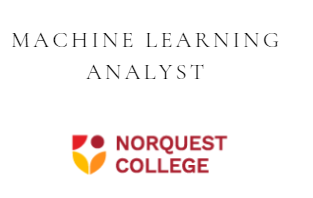

# Islamic Family Sample App

In [98]:
#install streamlit, one time execution
!pip install streamlit joblib

In [2]:
#import streamlit
import streamlit as st

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay

In [4]:
from geopy.geocoders import Nominatim
import time
import pandas as pd

# Broad areas you want to geocode
areas = [
    "NAIT/Kingway", "Boyle Street/McCauley", "Castle Downs", "Alberta Avenue",
    "Mill Woods", "Blue Quill", "Strathcona", "Jasper Place", "Bonnie Doon",
    "West Edmonton", "Calder/Kensington", "Oliver/Downtown", "Albany/Cumberland",
    "North Central", "University Area", "Meadowlark/Jasper Place", "Downtown",
    "Red Deer", "The Meadows"
]

geolocator = Nominatim(user_agent="edmonton_hamper_mapping")
results = []

for area in areas:
    try:
        location = geolocator.geocode(f"{area}, Edmonton, Alberta", timeout=10)
        if location:
            results.append({'broad_area': area, 'Latitude': location.latitude, 'Longitude': location.longitude})
        else:
            results.append({'broad_area': area, 'Latitude': None, 'Longitude': None})
    except Exception as e:
        results.append({'broad_area': area, 'Latitude': None, 'Longitude': None})
    time.sleep(1)

# Save to CSV
df_coords = pd.DataFrame(results)
df_coords.to_csv("geocoded_broad_areas.csv", index=False)


In [ ]:
import joblib

# Load the model
xgb_model = joblib.load('xgb_model.pkl')

# Get the feature names
booster = xgb_model.get_booster()
feature_names = booster.feature_names
print(feature_names)


['dependents_qty', 'primary_client_key', 'house_number', 'distance_km', 'month', 'week_of_month', 'broad_area_encoded', 'requests_per_household', 'Average household size', 'Couple-family households with children', 'Multigenerational households', 'One-parent families in which the parent is a man+', 'One-parent families in which the parent is a woman+', 'Persons not in census families - Living alone', 'Total one-parent families']


In [139]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
import os
import re
import pickle
import shap
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

# -------------------------------
# Area Mapping
# -------------------------------
broad_areas = [
    'Londonderry', 'NAIT/Kingway', 'Boyle Street/McCauley', 'Windermere', 'Castle Downs',
    'Northeast Edmonton', 'Clareview', 'Alberta Avenue', 'Mill Woods', 'Blue Quill',
    'Strathcona', 'Jasper Place', 'Malmo Plains', 'Bonnie Doon', 'Ellerslie',
    'West Edmonton', 'Calder/Kensington', 'Oliver/Downtown', 'Albany/Cumberland',
    'Beverly', 'North Central', 'University Area', 'Meadowlark/Jasper Place', 'Eastgate',
    'Capilano', 'The Hamptons', 'Terwillegar', 'Downtown', 'Red Deer', 'The Meadows', 'Camrose'
]
broad_area_mapping = {area: idx for idx, area in enumerate(broad_areas)}

# -------------------------------
# Load RAG components
# -------------------------------
@st.cache_resource
def load_rag():
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    generator = pipeline("text2text-generation", model="google/flan-t5-base")
    documents = {
    "doc1": "The Islamic Family is a compassionate, volunteer-driven community initiative dedicated to supporting families in need across Edmonton and surrounding areas. Their mission is to provide essential services such as food hampers, emotional support, and outreach programs to ensure no one is left behind. Rooted in values of care, dignity, and inclusion, the Islamic Family works with diverse partners and volunteers to uplift marginalized communities and build a stronger, more connected society. Learn more at their official website: https://www.islamicfamily.ca",

    "doc2": "Client 101 (Alice, Age 29) picked up a Standard hamper at Downtown on 2023-01-15. ...",

    "doc3": "The Islamic Family offers a wide range of services designed to uplift individuals and families. These include food hamper distribution, newcomer support, and culturally sensitive counseling. They provide mental health services integrated with Islamic values, family mediation, and wellness programs. For youth, they run The Green Room—a safe space for leadership, creativity, and support. They also offer mentorship through the Mirror program, educational workshops, re-entry support for individuals affected by incarceration, and inclusive community events. These services work together to support healing, empowerment, and belonging across Edmonton. Visit https://www.islamicfamily.ca for full details."
}

    doc_embeddings = {
        doc_id: embedder.encode(text, convert_to_tensor=True)
        for doc_id, text in documents.items()
    }
    return embedder, generator, documents, doc_embeddings

embedder, generator, documents, doc_embeddings = load_rag()

def retrieve_context(query, top_k=1):
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    similarities = {
        doc_id: util.pytorch_cos_sim(query_embedding, doc_embedding).item()
        for doc_id, doc_embedding in doc_embeddings.items()
    }
    sorted_docs = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    top_docs = [documents[doc_id] for doc_id, _ in sorted_docs[:top_k]]
    return " ".join(top_docs)

def rag_chatbot(query):
    context = retrieve_context(query)
    prompt = f"Context: {context}\n\nQuestion: {query}\n\nAnswer:"
    response = generator(
        prompt,
        max_length=250,          # ⬅️ Increase max length
        do_sample=False,         # ⬅️ Turn OFF randomness for more consistent responses
        num_return_sequences=1
    )[0]['generated_text']
    return response.strip()


# -------------------------------
# ML-based prediction logic
# -------------------------------
xgb_model = joblib.load("xgb_model.pkl")

# ✂️ Replace your old extract_features()
def extract_features(query):
    query = query.lower()

    # Defaults
    distance_km = 0
    requests_per_household = 0
    primary_client_key = 0
    house_number = 0
    month = 1
    week_of_month = 1
    avg_household_size = 0
    dependents_qty = 0

    # Extract broad area
    area = None
    for name in broad_area_mapping:
        if name.lower() in query:
            area = name
            break

    # Use regex to extract numbers for different features
    match = re.search(r'(\d+)\s+dependents?', query)
    if match:
        dependents_qty = int(match.group(1))

    match = re.search(r'(\d+(\.\d+)?)\s*(km|kilometers)', query)
    if match:
        distance_km = float(match.group(1))

    match = re.search(r'(\d+(\.\d+)?)\s*requests?', query)
    if match:
        requests_per_household = float(match.group(1))

    match = re.search(r'household size\s*(\d+)', query)
    if match:
        avg_household_size = float(match.group(1))

    match = re.search(r'month\s*(\d+)', query)
    if match:
        month = int(match.group(1))
        if not (1 <= month <= 12):
            month = 3  # default fallback

    match = re.search(r'week\s*(\d+)', query)
    if match:
        week_of_month = int(match.group(1))
        if not (1 <= week_of_month <= 4):
            week_of_month = 2  # default fallback

    if area is None:
        return None

    return {
        'dependents_qty': dependents_qty,
        'primary_client_key': primary_client_key,
        'house_number': house_number,
        'distance_km': distance_km,
        'month': month,
        'requests_per_household': requests_per_household,
        'week_of_month': week_of_month,
        'Average household size': avg_household_size,
        'broad_area_encoded': broad_area_mapping[area],
        'Couple-family households with children': 5265.0,
        'Multigenerational households': 195,
        'One-parent families in which the parent is a man+': 1950,
        'One-parent families in which the parent is a woman+': 2535,
        'Persons not in census families - Living alone': 1468,
        'Total one-parent families': 0
    }

def is_prediction_question(query):
    keywords = ["how many hampers", "predict", "estimate", "need"]
    return any(word in query.lower() for word in keywords)

# ✂️ Replace your old hybrid_chatbot()
def hybrid_chatbot(query):
    if is_prediction_question(query):
        features = extract_features(query)
        if features:
            input_df = pd.DataFrame([features])
            expected_columns = [
                'dependents_qty', 'primary_client_key', 'house_number', 'distance_km', 'month',
                'requests_per_household', 'week_of_month', 'Average household size', 'broad_area_encoded',
                'Couple-family households with children', 'Multigenerational households',
                'One-parent families in which the parent is a man+',
                'One-parent families in which the parent is a woman+',
                'Persons not in census families - Living alone', 'Total one-parent families'
            ]
            input_df = input_df[expected_columns]

            # Predict and scale
            hamper_pred = xgb_model.predict(input_df.values)[0]
            max_hamper_value = 100  # same as UI modeling
            hamper_pred = hamper_pred * max_hamper_value

            return f"📦 Based on our model, approximately **{int(round(hamper_pred))} hampers** may be needed."
        else:
            return "⚠️ Please mention a valid Edmonton area so I can estimate the hamper need."
    else:
        return rag_chatbot(query)
# -------------------------------
# Streamlit Page: Chatbot
# -------------------------------
def chatbot_page():
    st.title("🤖 Islamic Family Support Chatbot")

    if "chat_history" not in st.session_state:
        st.session_state.chat_history = []
    st.markdown("💬 **Example questions you can ask:**")
    example_prompts = [
    "Can you estimate how many hampers are needed in Londonderry for January, week 1, with 0 dependents and 0 requests?",
    "How many hampers are needed in Londonderry in January if the household is 10 km from the center but has no requests or dependents?",
    "Estimate hamper demand in Windermere for January, week 1, with 3 dependents, 2 requests per household, and average household size of 6.",
    "Tell me about the Islamic Family.",
    "What services are provided?",
    ]
    for prompt in example_prompts:
      st.markdown(f"👉 _{prompt}_")

    user_input = st.text_input("Ask something about food hamper support or predictions:")
    if st.button("Send"):
        if user_input:
            response = hybrid_chatbot(user_input)
            st.session_state.chat_history.append(("You", user_input))
            st.session_state.chat_history.append(("Bot", response))

    if user_input:
     response = hybrid_chatbot(user_input)
     st.markdown(f"**Bot:** {response}")


# -------------------------------------
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb


# Load the dataset with a specified encoding

# Page 1: Dashboard
def dashboard():
   st.image('Islamic Family.webp', caption="Islamic Family", use_container_width=True)

      # Add logos on the right (col3)

      # Highlight the project title
   st.title("Islamic Family Hamper Distribution Dashboard")

    # Add three summary statistics cards
   st.write("### Project Highlights")
   col1, col2, col3 = st.columns(3)
   col1.metric(label="Food hampers distributed monthly", value="2000+")
   col2.metric(label="Total volunteers engaged", value="2100")
   col3.metric(label="Neighborhoods Covered", value="40+")

    # Use tabs to organize content
   tab1, tab2, tab3 = st.tabs(["Abstract", "What the Project Does", "Inspiration"])

    # Abstract Tab
   with tab1:
        st.write("💡 **Abstract**")
        st.info(
            """
            This project focuses on identifying high-demand neighborhoods in Edmonton for Islamic food hamper distribution. Using past distribution records
            and socio-economic data, we built a machine learning model to predict which areas need the most support. The process involved data cleaning, analysis,
             and training regression and classification models. Our goal is to help Islamic organizations allocate resources more effectively and equitably.
            """
        )

    # What the Project Does Tab
   with tab2:
        st.write("👨🏻‍💻 **What Our Project Does**")
        bullet_points = [
            "Predicts food hamper demand across Edmonton neighborhoods using machine learning.",
            "Identifies key socio-economic factors influencing high-need areas.",
            "Analyzes past distribution data to uncover patterns and trends.",
            "Visualizes geographic and temporal trends in hamper distribution.",
            "Enhances planning for future food drives with data-driven insights.",
        ]
        for point in bullet_points:
            st.markdown(f"- {point}")

    # Inspiration Tab
   with tab3:
        st.write("🌟 **Inspiration**")
        st.warning(
            """
            The inspiration for this project came from the Islamic community’s ongoing efforts to support vulnerable families
             in Edmonton through food drives. While the intention and effort are strong, many of these initiatives face challenges
              in identifying which neighborhoods need the most support. By combining data science with community service, we aim to
               help Islamic organizations distribute food more effectively, ensuring that help reaches those who need it the most. Our goal is to turn compassion into targeted action through the power of data..
            """
        )
import streamlit as st
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

import streamlit as st






def explainable_ai_page():
    st.title("🧠 Explainable AI Insights")
    st.write("### Understanding What Drives Food Hamper Needs")

    # Load model
    booster = xgb.Booster()
    booster.load_model("xgb_model.json")

    # Load data
    X_train = pd.read_csv("X_train.csv")
    X_test = pd.read_csv("X_test.csv")
    y_test = pd.read_csv("y_test.csv")

    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, 0]

    # Predict using Booster and DMatrix
    y_pred = booster.predict(xgb.DMatrix(X_test))

    # If output is 2D (multi-output), use only column 0
    if y_pred.ndim == 2:
        y_pred = y_pred[:, 0]

    # Now calculate residuals
    residuals = np.ravel(y_test) - np.ravel(y_pred)

    # Residuals
    y_pred = np.ravel(y_pred)
    y_test = np.ravel(y_test.values)
    residuals = y_test - y_pred

    # 📉 Residual Plot
    st.subheader("📉 Residual Plot")
    st.markdown("This plot shows how accurate our model is. The closer the dots are to the red line, the better the predictions.")

    fig1, ax1 = plt.subplots()
    sns.scatterplot(x=y_pred, y=residuals, ax=ax1)
    ax1.axhline(0, color='red', linestyle='--')
    ax1.set_xlabel("Predicted Hamper Demand")
    ax1.set_ylabel("Residuals")
    ax1.set_title("Residual Plot for Hamper Demand")
    st.pyplot(fig1)


    # 🧠 SHAP Summary Plot
    st.subheader("📌 SHAP Summary Plot")


    # Create SHAP explainer
    explainer = shap.Explainer(booster)
    shap_values = explainer(X_test)

    # Plot to matplotlib figure and display in Streamlit
    st.subheader("SHAP Summary Plot - Hamper Demand")
    st.markdown("""
🧠 **Interpretation Tip**
Each dot represents one prediction made by the model.

- **Position**: The further a dot is from the center (left or right), the more impact that feature had on the prediction.
- **Color**: Indicates the feature value.
   - **Red = high value**
   - **Blue = low value**

📌 For example, more **dependents** (red dots on the right) tend to **increase** predicted hamper demand.
Lower **distance** (blue dots on the left) may **decrease** the prediction slightly.

This helps us see which features matter the most when estimating food hamper needs.
""")

    fig_summary, ax_summary = plt.subplots()
    shap.summary_plot(shap_values.values, X_test, show=False)
    st.pyplot(fig_summary)


        # Only keep first target's SHAP values (hamper_demand)
    X_test_shap = pd.read_csv("X_test.csv")  # ← this loads your SHAP input
    shap_values = explainer(X_test_shap)

    shap_vals_hamper = shap_values.values  # ✅ correct for regression

    # Check shape consistency
    if shap_vals_hamper.shape[0] != X_test_shap.shape[0]:
        st.error("Mismatch in SHAP values and test data samples!")
    else:
        # Compute mean importance
        shap_importance = np.abs(shap_vals_hamper).mean(axis=0)
        top_indices = np.argsort(shap_importance)[-5:][::-1]

        top_features = [X_test_shap.columns[i] for i in top_indices]

        st.subheader("Dependence Plots (Top 5)")
        st.markdown("""
📊 **Dependence Plot Guide**

These plots show how each top feature affects the model’s prediction, one at a time.

- **X-axis**: The actual value of the feature (e.g., number of dependents).
- **Y-axis**: The SHAP value (how much that feature pushed the prediction up or down).
- **Color**: Shows interaction with another feature (e.g., distance or dependents).

### How to read this:
- If the dots go **upward**, higher values of the feature **increase** the predicted hamper demand.
- If they go **downward**, higher values **decrease** the prediction.

📌 Example:
In the `dependents_qty` plot, as the number of dependents increases, the model tends to predict **more** food hampers needed.

These insights help us understand what factors influence need in each neighborhood.
""")

    for feature in top_features:
      st.write(f"SHAP Dependence Plot: {feature}")
      shap.dependence_plot(feature, shap_vals_hamper, X_test_shap, show=False)
      fig = plt.gcf()
      st.pyplot(fig)
      plt.clf()




    st.success("SHAP-based insights generated using the XGBoost `.json` model.")
# Page 3: Machine Learning Modeling
import streamlit as st
import pandas as pd
import pickle

def machine_learning_modeling():
    st.title("📦 Hamper Demand Prediction")
    st.write("Fill in the household and request details below:")

    try:
        # 📥 User Inputs
        dependents = st.number_input("👨‍👩‍👧 Number of Dependents", min_value=0)
        distance = st.number_input("📍 Distance (km) from center", min_value=0.0)
        month = st.selectbox("📆 Month", list(range(1, 13)))
        requests = st.number_input("📝 Requests per Household", min_value=0.0)
        week = st.selectbox("📅 Week of Month", [1, 2, 3, 4])
        avg_size = st.number_input("👥 Average Household Size", min_value=0.0)

        # 📍 Broad Area selection (full list)
        broad_areas = [
            'Londonderry', 'NAIT/Kingway', 'Boyle Street/McCauley', 'Windermere', 'Castle Downs',
            'Northeast Edmonton', 'Clareview', 'Alberta Avenue', 'Mill Woods', 'Blue Quill',
            'Strathcona', 'Jasper Place', 'Malmo Plains', 'Bonnie Doon', 'Ellerslie',
            'West Edmonton', 'Calder/Kensington', 'Oliver/Downtown', 'Albany/Cumberland',
            'Beverly', 'North Central', 'University Area', 'Meadowlark/Jasper Place', 'Eastgate',
            'Capilano', 'The Hamptons', 'Terwillegar', 'Downtown', 'Red Deer', 'The Meadows', 'Camrose'
        ]
        broad_area_mapping = {area: idx for idx, area in enumerate(broad_areas)}
        broad_area = st.selectbox("🏘️ Broad Area", broad_areas)
        broad_area_encoded = broad_area_mapping[broad_area]

        # 👻 Default socio-economic features (dummy values for now)
        input_data = pd.DataFrame([{
            'dependents_qty': dependents,
            'primary_client_key': 0,
            'house_number': 0,
            'distance_km': distance,
            'month': month,
            'requests_per_household': requests,
            'week_of_month': week,
            'Average household size': avg_size,
            'broad_area_encoded': broad_area_encoded,
            'Couple-family households with children': 5265.0,
            'Multigenerational households': 195,
            'One-parent families in which the parent is a man+': 1950,
            'One-parent families in which the parent is a woman+': 2535,
            'Persons not in census families - Living alone': 1468,
            'Total one-parent families': 0
        }])

        # ✅ Ensure correct feature order (must match model exactly)
        expected_columns = [
    'dependents_qty', 'primary_client_key', 'house_number', 'distance_km', 'month',
    'requests_per_household', 'week_of_month', 'Average household size', 'broad_area_encoded',
    'Couple-family households with children', 'Multigenerational households',
    'One-parent families in which the parent is a man+',
    'One-parent families in which the parent is a woman+',
    'Persons not in census families - Living alone', 'Total one-parent families'
          ]

        input_data = input_data[expected_columns]

        # 🔍 Load Trained Model
        try:
            with open("xgb_model.pkl", "rb") as f:
                model = pickle.load(f)
        except Exception as e:
            st.error(f"❌ Failed to load model: {e}")
            return

        # 🔮 Make Prediction
        hamper_pred = model.predict(input_data.values)[0]

        # ✅ Display Result
        # 🔍 Multiply by max value used during model training to rescale
        max_hamper_value = 100  # Replace this with the actual max hamper demand from your training set
        hamper_pred = hamper_pred * max_hamper_value

        st.success(f"📦 Predicted Hamper Demand: **{int(round(hamper_pred))} hampers**")



    except Exception as e:
        st.error(f"❌ Unexpected error: {e}")

# Page 4: Neighbourhood Mapping

# Read geospatial data

import streamlit as st
import pandas as pd
import plotly.express as px

def hamper_demand_map():
    st.title("📍 Hamper Demand Map by Broad Area")

    # Load main data and combined coordinates
    df = pd.read_csv("df_merged_backup.csv")
    coords = pd.read_csv("geocoded_broad_areas.csv")
    manual_coords = pd.read_csv("location.csv")

    # Clean and combine both coordinate sources
    coords['broad_area'] = coords['broad_area'].astype(str).str.strip().str.title()
    manual_coords = manual_coords.rename(columns={"Neighbourhood": "broad_area"})
    manual_coords['broad_area'] = manual_coords['broad_area'].astype(str).str.strip().str.title()

    # Combine both sources
    all_coords = pd.concat([manual_coords[['broad_area', 'Latitude', 'Longitude']],
                            coords[['broad_area', 'Latitude', 'Longitude']]])
    all_coords = all_coords.drop_duplicates(subset='broad_area', keep='first')

    # Prepare df and merge with coordinates
    df['broad_area_clean'] = df['broad_area'].astype(str).str.strip().str.title()
    df = pd.merge(df, all_coords, left_on='broad_area_clean', right_on='broad_area', how='left')
    df = df.dropna(subset=['Latitude', 'Longitude'])

    # Group data for plotting
    summary = df.groupby('broad_area_clean', as_index=False).agg({
        'hamper_demand': lambda x: int(round(x.mean())),
        'Latitude': 'first',
        'Longitude': 'first'
    })

    # Plot
    fig = px.scatter_mapbox(
        summary,
        lat='Latitude',
        lon='Longitude',
        color='hamper_demand',
        hover_name='broad_area_clean',
        hover_data={'hamper_demand': True},
        zoom=10,
        title="Hamper Demand by Broad Area"
    )
    fig.update_layout(mapbox_style='open-street-map')
    st.plotly_chart(fig)

def interactive_eda_page():
    st.title("📊 Interactive EDA - Hamper Demand Insights")
    st.write("Use the filters below to explore hamper demand and volunteer data across neighborhoods.")

    # Load data
    df = pd.read_csv("df_merged_backup.csv")

    # Clean area names
    df['broad_area_clean'] = df['broad_area'].astype(str).str.strip().str.title()

    # Filter widgets
    area_list = sorted(df['broad_area_clean'].dropna().unique())
    selected_area = st.selectbox("🏘️ Select Broad Area", area_list)
    month_dict = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
      }
    month_name = st.selectbox("📅 Select Month", list(month_dict.keys()))
    selected_month = month_dict[month_name]

    # Filtered DataFrame
    filtered_df = df[(df['broad_area_clean'] == selected_area) & (df['month'] == selected_month)]

    st.markdown(f"### 📌 Overview for **{selected_area}**")

    # 📦 Hamper Demand by Week of Month
    if 'week_of_month' in filtered_df.columns:
        fig1 = px.bar(filtered_df, x='week_of_month', y='hamper_demand',
                      title="📦 Hamper Demand by Week",
                      labels={'week_of_month': 'Week of Month', 'hamper_demand': 'Hamper Demand'})
        st.plotly_chart(fig1)

        # 📈 Hamper Demand by Month (Interactive Bar Chart)
    st.markdown("### 📦 Monthly Hamper Demand Overview")

    # Ensure necessary columns exist
    if 'month' in df.columns and 'hamper_demand' in df.columns:
        # Map month number to name
        month_dict = {
            1: 'January', 2: 'February', 3: 'March', 4: 'April',
            5: 'May', 6: 'June', 7: 'July', 8: 'August',
            9: 'September', 10: 'October', 11: 'November', 12: 'December'
        }

        # Group by month and sum hamper demand
        month_demand = df.groupby('month')['hamper_demand'].sum().reset_index()
        month_demand['Month Name'] = month_demand['month'].astype(int).map(month_dict)

        # Sort by calendar month
        month_demand = month_demand.sort_values('month')

        # Plot
        fig_month = px.bar(
            month_demand,
            x='Month Name',
            y='hamper_demand',
            title="📅 Total Hamper Demand by Month",
            labels={'hamper_demand': 'Total Hamper Demand', 'Month Name': 'Month'},
            color='hamper_demand',
            color_continuous_scale='Blues'
        )

        st.plotly_chart(fig_month)


    # 👨‍👩‍👧 Dependents Distribution
    if 'dependents_qty' in filtered_df.columns:
        fig2 = px.histogram(filtered_df, x='dependents_qty', nbins=10,
                            title="👨‍👩‍👧 Dependents Distribution",
                            labels={'dependents_qty': 'Number of Dependents'})
        st.plotly_chart(fig2)

    # 📍 Distance from Center
    if 'distance_km' in filtered_df.columns:
        fig3 = px.histogram(filtered_df, x='distance_km', nbins=10,
                            title="📍 Distance from Center",
                            labels={'distance_km': 'Distance (km)'})
        st.plotly_chart(fig3)

    # 👥 Average Household Size across Areas (New Plot)
    if 'Average household size' in df.columns:
        avg_household = df.groupby('broad_area_clean')['Average household size'].mean().reset_index()
        fig4 = px.bar(avg_household, x='broad_area_clean', y='Average household size',
                      title='👥 Average Household Size by Area',
                      labels={'broad_area_clean': 'Broad Area', 'Average household size': 'Avg. Household Size'})
        fig4.update_layout(xaxis_tickangle=-45)
        st.plotly_chart(fig4)

    # 📊 Socio-Economic Factors Across All Areas
    # 📊 Overall Socio-Economic Household Type Distribution (Pie Chart)
    st.markdown("### 🏘️ Overall Socio-Economic Household Composition")

    # List of relevant columns
    socio_cols = [
        'Couple-family households with children',
        'Multigenerational households',
        'One-parent families in which the parent is a man+',
        'One-parent families in which the parent is a woman+',
        'Persons not in census families - Living alone',
        'Total one-parent families'
    ]

    # Ensure all required columns exist
    if all(col in df.columns for col in socio_cols):
        # Aggregate total counts across all rows
        overall_household_summary = df[socio_cols].sum()

        # Plot as pie chart
        fig_pie = px.pie(
            names=overall_household_summary.index,
            values=overall_household_summary.values,
            title="Household Type Distribution Across All Areas",
            hole=0.4
        )
        st.plotly_chart(fig_pie)




# Page 5: Data Collection
def data_collection():
    st.title("Registration form")
    st.write("Please fill out the Google form to register to be a member of Islamic Family!")
    google_form_url = "https://docs.google.com/forms/d/e/1FAIpQLSdAczaPFRHCfVeq-qOVkHwn9QE3aCR5I-1xkJhV0XImfWF9Xg/viewform?usp=dialog"
    st.markdown(f"[Fill out the form]({google_form_url})")

def thank_you_page():
    st.title("Thank You to Our Stakeholders!")

    # Add a thank you message
    st.write(
        """
        We extend our heartfelt gratitude to our amazing stakeholders for their invaluable support in making this project a success.
        Your contributions and dedication have made a meaningful impact on our community.
        """
    )

    # Create a layout with columns for displaying logos
    st.write("### Our Stakeholders:")
    st.image('67364fb3e83436f479ca372a_IF-Homepage-Hero.webp', caption="The Islamic Family", use_container_width=True)


    # Add a footer with a final thank you message
    st.write("---")
    st.subheader("Together, we are making a difference!")



# -------------------------------------
def main():
    st.sidebar.title("Islamic Family App")
    app_page = st.sidebar.radio("Select a Page", [
        "Dashboard",
        "Interactive EDA",
        "Neighbourhood Mapping",
        "ML Modeling",
        "Explainable AI",
        "Chatbot",  # This appears first
        "Data Collection",
        "Thank You"
    ])


    if app_page == "Dashboard":
        dashboard()  # Call your dashboard function
    elif app_page == "Interactive EDA":
        interactive_eda_page()
    elif app_page == "Neighbourhood Mapping":
        hamper_demand_map()
    elif app_page == "ML Modeling":
        machine_learning_modeling()
    elif app_page == "Explainable AI":
        explainable_ai_page()
    elif app_page == "Chatbot":
        chatbot_page()
    elif app_page == "Data Collection":
        data_collection()
    elif app_page == "Thank You":
        thank_you_page()

if __name__ == "__main__":
    main()


Overwriting app.py


## Install localtunnel

In [140]:
!npm install localtunnel

⠙⠹⠸⠼
up to date, audited 23 packages in 906ms
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠴

## Run streamlit in background

In [141]:
!streamlit run /content/app.py &>/content/logs.txt & curl ipv4.icanhazip.com

34.138.166.236


Copy this IP address.

## Expose the port 8501
Then just click in the `url` showed.

A `log.txt`file will be created.

In [142]:
!npx localtunnel --port 8501

⠙your url is: https://brown-mice-argue.loca.lt
^C
